# Building Network Models

@[Xiaoyu Chen](mailto:c-xy17@tsinghua.org.cn) @[Chaoming Wang](https://github.com/chaoming0625)

In previous sections, it has been illustrated how to define neuron models by `brainpy.dyn.NeuGroup` and synapse models by `brainpy.dyn.TwoEndConn`. This section will introduce `brainpy.dyn.Network`, which is the base class used to build network models.

In essence, [brainpy.dyn.Network](../apis/auto/building/generated/brainpy.dyn.Network.rst) is a container, whose function is to compose the individual elements. It is a subclass of a more general class: [brainpy.dyn.Container](../apis/auto/building/generated/brainpy.dyn.Container.rst). 

In below, we take an excitation-inhibition (E-I) balanced network model as an example to illustrate how to compose the [LIF neurons](./neuron_models.ipynb) and [Exponential synapses](./synapse_models.ipynb) defined in previous tutorials to build a network. 

In [1]:
import brainpy as bp

# bp.math.set_platform('cpu')

bp.__version__

'2.3.0'

## Excitation-Inhibition (E-I) Balanced Network

The E-I balanced network was first proposed to explain the irregular firing patterns of cortical neurons and comfirmed by experimental data. The network [1] we are going to implement consists of excitatory (E) neurons and inhibitory (I) neurons, the ratio of which is about 4 : 1. The biggest difference between excitatory and inhibitory neurons is the reversal potential - the reversal potential of inhibitory neurons is much lower than that of excitatory neurons. Besides, the membrane time constant of inhibitory neurons is longer than that of excitatory neurons, which indicates that inhibitory neurons have slower dynamics.

[1] Brette, R., Rudolph, M., Carnevale, T., Hines, M., Beeman, D., Bower, J. M., et al. (2007), Simulation of networks of spiking neurons: a review of tools and strategies., J. Comput. Neurosci., 23, 3, 349–98.

In [2]:
# BrianPy has some built-in canonical neuron and synapse models

LIF = bp.neurons.LIF
Exponential = bp.synapses.Exponential

## Two ways to define network models

There are several ways to define a Network model. 

### 1. Defining a network as a class

The first way to define a network model is like follows. 

In [3]:
class EINet(bp.dyn.Network):
  def __init__(self, num_exc, num_inh, method='exp_auto', **kwargs):
    super(EINet, self).__init__(**kwargs)

    # neurons
    pars = dict(V_rest=-60., V_th=-50., V_reset=-60., tau=20., tau_ref=5.)
    E = LIF(num_exc, **pars, method=method)
    I = LIF(num_inh, **pars, method=method)
    E.V.value = bp.math.random.randn(num_exc) * 2 - 55.
    I.V.value = bp.math.random.randn(num_inh) * 2 - 55.

    # synapses
    w_e = 0.6  # excitatory synaptic weight
    w_i = 6.7  # inhibitory synaptic weight
    E_pars = dict(output=bp.synouts.COBA(E=0.), g_max=w_e, tau=5.)
    I_pars = dict(output=bp.synouts.COBA(E=-80.), g_max=w_i, tau=10.)
    
    # Neurons connect to each other randomly with a connection probability of 2%
    self.E2E = Exponential(E, E, bp.conn.FixedProb(prob=0.02), **E_pars, method=method)
    self.E2I = Exponential(E, I, bp.conn.FixedProb(prob=0.02), **E_pars, method=method)
    self.I2E = Exponential(I, E, bp.conn.FixedProb(prob=0.02), **I_pars, method=method)
    self.I2I = Exponential(I, I, bp.conn.FixedProb(prob=0.02), **I_pars, method=method)

    self.E = E
    self.I = I

In an instance of ``brainpy.dyn.Network``,  all ``self.`` accessed elements can be gathered by the ``.nodes()`` function automatically.

In [4]:
EINet(8, 2).nodes(level=-1).subset(bp.dyn.DynamicalSystem)

{'EINet0': EINet(),
 'Exponential0': Exponential(name=Exponential0, mode=NormalMode, 
             pre=LIF(name=LIF0, mode=NormalMode, size=(8,)), 
             post=LIF(name=LIF0, mode=NormalMode, size=(8,))),
 'Exponential1': Exponential(name=Exponential1, mode=NormalMode, 
             pre=LIF(name=LIF0, mode=NormalMode, size=(8,)), 
             post=LIF(name=LIF1, mode=NormalMode, size=(2,))),
 'Exponential2': Exponential(name=Exponential2, mode=NormalMode, 
             pre=LIF(name=LIF1, mode=NormalMode, size=(2,)), 
             post=LIF(name=LIF0, mode=NormalMode, size=(8,))),
 'Exponential3': Exponential(name=Exponential3, mode=NormalMode, 
             pre=LIF(name=LIF1, mode=NormalMode, size=(2,)), 
             post=LIF(name=LIF1, mode=NormalMode, size=(2,))),
 'LIF0': LIF(name=LIF0, mode=NormalMode, size=(8,)),
 'LIF1': LIF(name=LIF1, mode=NormalMode, size=(2,)),
 'COBA2': COBA,
 'NullSynSTP1': NullSynSTP,
 'NullSynLTP0': NullSynLTP,
 'COBA4': COBA,
 'NullSynSTP2': NullSy

Note in the above ``EINet``, we do not define the ``update()`` function. This is because any subclass of ``brainpy.dyn.Network`` has a default update function, in which it automatically gathers the elements defined in this network and sequentially runs the update function of each element.

Let's try to simulate our defined `EINet` model. 

  0%|          | 0/1000 [00:00<?, ?it/s]

Used time None s


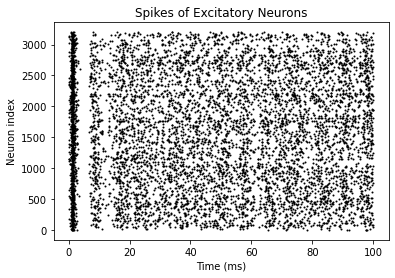

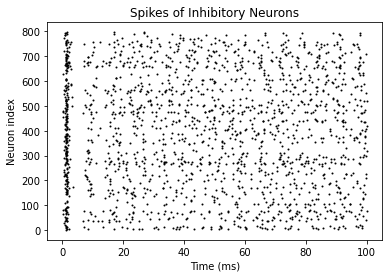

In [5]:
net = EINet(3200, 800, method='exp_auto')  # "method": the numerical integrator method

runner = bp.dyn.DSRunner(net,
                         monitors=['E.spike', 'I.spike'],
                         inputs=[('E.input', 20.), ('I.input', 20.)])
t = runner.run(100.)
print(f'Used time {t} s')

# visualization
bp.visualize.raster_plot(runner.mon.ts, runner.mon['E.spike'],
                         title='Spikes of Excitatory Neurons', show=True)
bp.visualize.raster_plot(runner.mon.ts, runner.mon['I.spike'],
                         title='Spikes of Inhibitory Neurons', show=True)

### 2. Instantiating a network directly

Another way to instantiate a network model is directly pass the elements into the constructor of ``brainpy.Network``. It receives ``*args`` and ``**kwargs`` arguments.

In [6]:
# neurons
pars = dict(V_rest=-60., V_th=-50., V_reset=-60., tau=20., tau_ref=5.)
E = LIF(3200, **pars)
I = LIF(800, **pars)
E.V.value = bp.math.random.randn(E.num) * 2 - 55.
I.V.value = bp.math.random.randn(I.num) * 2 - 55.

# synapses
E_pars = dict(output=bp.synouts.COBA(E=0.), g_max=0.6, tau=5.)
I_pars = dict(output=bp.synouts.COBA(E=-80.), g_max=6.7, tau=10.)
E2E = Exponential(E, E, bp.conn.FixedProb(prob=0.02), **E_pars)
E2I = Exponential(E, I, bp.conn.FixedProb(prob=0.02), **E_pars)
I2E = Exponential(I, E, bp.conn.FixedProb(prob=0.02), **I_pars)
I2I = Exponential(I, I, bp.conn.FixedProb(prob=0.02), **I_pars)


# Network
net2 = bp.dyn.Network(E2E, E2I, I2E, I2I, exc_group=E, inh_group=I)

All elements are passed as ``**kwargs`` argument can be accessed by the provided keys. This will affect the following dynamics simulation.

In [7]:
net2.exc_group

LIF(name=LIF4, mode=NormalMode, size=(3200,))

In [8]:
net2.inh_group

LIF(name=LIF5, mode=NormalMode, size=(800,))

After construction, the simulation goes the same way:

  0%|          | 0/1000 [00:00<?, ?it/s]

Used time None s


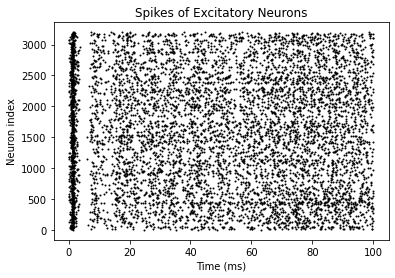

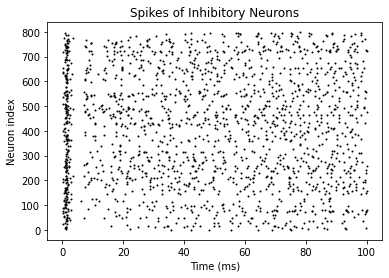

In [9]:
runner = bp.dyn.DSRunner(net2,
                         monitors=['exc_group.spike', 'inh_group.spike'],
                         inputs=[('exc_group.input', 20.), ('inh_group.input', 20.)])
t = runner.run(100.)
print(f'Used time {t} s')

# visualization
bp.visualize.raster_plot(runner.mon.ts, runner.mon['exc_group.spike'],
                         title='Spikes of Excitatory Neurons', show=True)
bp.visualize.raster_plot(runner.mon.ts, runner.mon['inh_group.spike'],
                         title='Spikes of Inhibitory Neurons', show=True)

## Customizing update function

If you want to control your updating logic in a network, you can overwrite the updating function ``update(tdi)`` and customize it by yourself.

For the above E/I balanced network model, we can define its update function as:

In [10]:
class EINetV2(bp.dyn.Network):
  def __init__(self, num_exc, num_inh, method='exp_auto', **kwargs):
    super(EINetV2, self).__init__(**kwargs)

    # neurons
    self.N = LIF(num_exc + num_inh,
                 V_rest=-60., V_th=-50., V_reset=-60., tau=20., tau_ref=5.,
                 method=method, V_initializer=bp.init.Normal(-55., 2.))

    # synapses
    self.Esyn = bp.synapses.Exponential(self.N[:num_exc], self.N,
                                        bp.conn.FixedProb(prob=0.02),
                                        output=bp.synouts.COBA(E=0.),
                                        g_max=0.6, tau=5.,
                                        method=method)
    self.Isyn = bp.synapses.Exponential(self.N[num_exc:], self.N,
                                        bp.conn.FixedProb(prob=0.02),
                                        output=bp.synouts.COBA(E=-80.),
                                        g_max=6.7, tau=10.,
                                        method=method)

  def update(self, tdi):
    self.Esyn(tdi)
    self.Isyn(tdi)
    self.N(tdi)
    self.update_local_delays()  # IMPORTANT

In the above, we define one population, and create E (excitatory) and I (inhibitory) projections within this population. Then, we first update synapse models by calling `self.Esyn(tdi)` and `self.Isyn(tdi)`. This operation can ensure that all synapse inputs can be gathered onto neuron models before we update neurons. After updating synapses, we update the state of neurons by calling ``self.N(tdi)``. Finally, it's worthy to note that we need to update all delays used in this network through ``self.update_local_delays()``. This is because delay variables relying on neurons. Once upon neuronal states have been updated, we need to update delays according to these new values of neuronal states.

  0%|          | 0/1000 [00:00<?, ?it/s]

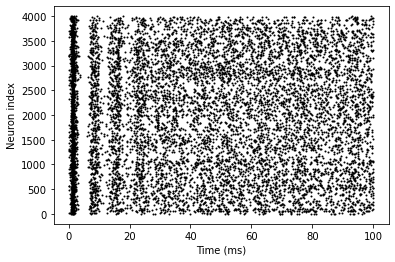

In [11]:
net = EINetV2(3200, 800)
runner = bp.dyn.DSRunner(net, monitors={'spikes': net.N.spike}, inputs=[(net.N.input, 20.)])
runner.run(100.)
bp.visualize.raster_plot(runner.mon.ts, runner.mon['spikes'], show=True)